## Phase 1: Data Sanitation and Preprocessing
### Load Data
In this phase, we load the dataset into a pandas DataFrame.  
We use a `try-except` block so that the notebook does not crash if the file is missing.  
The dataset is encoded in **ISO-8859-1** because it contains special characters that cannot be read with the default UTF-8 encoding.


In [2]:
import pandas as pd

# Load the dataset
file_path = 'Data/online_retail.csv'
try:
    df = pd.read_csv(file_path, encoding='ISO-8859-1')
    print('Dataset loaded successfully.')
except FileNotFoundError:
    print(f'Error: The file was not found at {file_path}')

Dataset loaded successfully.


### Explanation:
- `pd.read_csv()` is used to load the CSV file into a pandas DataFrame.  
- The **ISO-8859-1 encoding** ensures that special characters (such as non-English text) load correctly.  
- A `try-except` block is used for **reproducibility**:  
  - If the file exists in the correct folder, it will load successfully.  
  - If not, the notebook will return a clear error message instead of breaking.  


### Previewing the Dataset

After loading the dataset, it is important to preview the data to understand its structure.  
We use `head()` and `tail()` methods to look at the first and last few rows of the DataFrame.  
This helps us confirm that the dataset loaded correctly and get a quick sense of the columns and sample values.


In [3]:
# Display the first 5 rows of the dataframe
df.head()

# Display the last 5 rows of the dataframe
#df.tail()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


### Explanation:
- `df.head()` shows the **first 5 rows** of the dataset. This is useful for verifying that the columns and values are correctly loaded.  
- `df.tail()` shows the **last 5 rows** of the dataset. We commented it out here (`#df.tail()`) but it can be used if we want to check the bottom of the dataset.  
- Together, these methods give us a quick overview of the dataset without scrolling through the entire file.  


### Dataset Summary

To better understand the dataset, we generate a concise summary using the `info()` method.  
This provides details about the structure of the DataFrame, including column names, data types, and the presence of missing values.


In [4]:
# Get a concise summary of the dataframe
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


### Explanation:
- `df.info()` shows:
  - The **number of rows and columns** in the dataset.  
  - The **column names** and their respective **data types** (e.g., integer, float, object/string).  
  - The **non-null count** for each column, which helps us quickly identify columns with missing values.  
- This step is important because it gives us an overview of the dataset’s structure and highlights any potential data quality issues we need to address later in the cleaning phase.  


### Removing Duplicate Records

Duplicate rows can appear in a dataset due to data entry errors or repeated transactions.  
If not removed, they may bias the analysis (e.g., overcounting purchases).  
We use `drop_duplicates()` to eliminate any duplicate records from the dataset.


In [5]:
# Remove duplicate rows
df = df.drop_duplicates()
print(f"After dropping duplicates: {df.shape}")

After dropping duplicates: (1033036, 8)


### Explanation:
- `df.drop_duplicates()` removes any rows that are exact duplicates of others.  
- We assign the result back to `df` so the DataFrame is updated without duplicates.  
- `df.shape` shows the new dimensions (rows × columns) after removing duplicates, which lets us confirm how many records were dropped.  
- This ensures the dataset is **clean and accurate** before moving forward with analysis.  


### Handling Missing Customer IDs

Some transactions in the dataset may not have a `Customer ID`.  
Since customer-level analysis (e.g., RFM segmentation) requires identifying each unique customer, rows without a `Customer ID` cannot be used.  
Here, we drop those rows and convert the `Customer ID` column to an integer type.


In [6]:
# Drop rows with missing Customer ID, then convert to int
missing_cust = df['Customer ID'].isnull().sum()
print(f"Rows with missing Customer ID: {missing_cust}")
df = df.dropna(subset=['Customer ID'])
df['Customer ID'] = df['Customer ID'].astype(int)

Rows with missing Customer ID: 235151


### Explanation:
- `df['Customer ID'].isnull().sum()` counts how many rows have a missing customer ID.  
- `df.dropna(subset=['Customer ID'])` removes those rows because they cannot be linked to any customer.  
- Finally, we use `astype(int)` to convert the `Customer ID` column from float to integer for consistency.  
- This ensures every record in the dataset is tied to a valid customer, which is essential for accurate customer segmentation.  


### Removing Cancelled Invoices

In the dataset, invoices that start with the letter **'C'** represent **cancelled transactions** (e.g., returns or order cancellations).  
Including them would distort our revenue and frequency analysis, so we remove these cancelled invoices.


In [7]:
# Remove cancelled invoices (Invoice starts with 'C')
cancelled = df['Invoice'].astype(str).str.startswith('C').sum()
print(f"Cancelled invoices: {cancelled}")
df = df[~df['Invoice'].astype(str).str.startswith('C')]

Cancelled invoices: 18390


### Explanation:
- `df['Invoice'].astype(str).str.startswith('C').sum()` counts how many invoices are cancelled.  
- We then filter the DataFrame using `~ ... .startswith('C')` to **exclude** those rows.  
- This ensures our dataset contains only valid purchase transactions.  
- Removing cancellations helps maintain the accuracy of revenue calculations and customer behavior analysis.  


### Removing Rows with Zero Price

Transactions with a `Price` of zero are either errors or special cases that do not contribute to revenue.  
Including them could distort monetary analysis, so we remove these rows from the dataset.


In [8]:
# Remove rows where Price is zero
zero_price = (df['Price'] == 0).sum()
print(f"Rows with Price == 0: {zero_price}")
df = df[df['Price'] > 0]

Rows with Price == 0: 70


### Explanation:
- `(df['Price'] == 0).sum()` counts how many rows have a price of zero.  
- `df[df['Price'] > 0]` filters out these rows, keeping only valid transactions with a positive price.  
- This step ensures that all monetary calculations (e.g., total revenue, RFM analysis) are accurate and not affected by invalid or placeholder values.  

### Removing Non-Product StockCodes

The dataset contains some StockCodes that do not represent actual products, such as postage, bank charges, or miscellaneous entries.  
These rows are not relevant for product-level or revenue analysis, so we filter them out.


In [9]:
# Remove non-product StockCodes
non_product_codes = ['POST', 'D', 'M', 'BANK CHARGES', 'PADS', 'C2', 'DOT']
mask = ~df['StockCode'].isin(non_product_codes)
print(f"Non-product rows removed: {(~mask).sum()}")
df = df[mask]

Non-product rows removed: 2801


### Explanation:
- `non_product_codes` lists all StockCodes that are not actual products.  
- `~df['StockCode'].isin(non_product_codes)` creates a mask to **keep only real product rows**.  
- `( ~mask ).sum()` counts how many non-product rows are removed, providing a quick verification.  
- This cleaning step ensures that the dataset focuses solely on actual products, which improves the accuracy of revenue and product-level analysis.  

### Feature Engineering – Calculating TotalPrice

To analyze revenue per transaction, we create a new column `TotalPrice` which represents the total value of each transaction.  
This is calculated by multiplying the quantity of items purchased by the unit price.


In [10]:
# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['Price']

### Explanation:
- `df['Quantity'] * df['Price']` computes the total revenue generated from each transaction.  
- Storing this value in a new column `TotalPrice` allows for easier aggregation and analysis, such as total revenue per customer, product, or invoice.  
- This is an essential step for subsequent RFM analysis and revenue-based insights.  

### Feature Engineering – Extracting Year and Month

To enable time-based analysis, we extract the **Year** and **Month** from the `InvoiceDate` column.  
This allows us to analyze trends over time, such as monthly sales or yearly revenue.

In [28]:
# Add Year and Month columns
df['Year'] = pd.to_datetime(df['InvoiceDate']).dt.year
df['Month'] = pd.to_datetime(df['InvoiceDate']).dt.month

### Explanation:
- `pd.to_datetime(df['InvoiceDate'])` converts the `InvoiceDate` column to a datetime object, enabling time-based operations.  
- `.dt.year` extracts the year, and `.dt.month` extracts the month from each invoice date.  
- Adding these columns helps in aggregating sales data by month or year and identifying seasonal trends.  

### Verifying Data Types

After cleaning and feature engineering, it is important to check the data types of each column.  
This ensures that all columns have the correct type for further analysis, such as numeric calculations and datetime operations.

In [11]:
# Print final data types
print(df.dtypes)

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID      int64
Country         object
TotalPrice     float64
dtype: object


### Explanation:
- `df.dtypes` displays the data type of each column in the DataFrame.  
- Verifying data types helps confirm that:
  - `Customer ID` is an integer
  - `Quantity` and `Price` are numeric
  - `InvoiceDate` is a datetime
  - Newly created columns like `TotalPrice`, `Year`, and `Month` have the correct types  
- Correct data types are essential for accurate analysis and prevent errors in subsequent steps like aggregation or RFM calculation.

### Checking for Missing Values

Before performing analysis, it is important to identify any remaining missing values in the dataset.  
Missing values can affect calculations, aggregations, and model accuracy, so we need to be aware of them.

In [12]:
# Check for missing values
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
TotalPrice     0
dtype: int64

### Explanation:
- `df.isnull().sum()` counts the number of missing values in each column.  
- This helps us quickly identify any columns that still contain null values after the cleaning steps.  
- Knowing where missing values exist allows us to decide whether to **drop them, fill them, or handle them differently** before proceeding to analysis or RFM segmentation.  

## Analysis – Top 10 Best-Selling Products

To understand product performance, we identify the top-selling products based on total quantity sold.  
This helps highlight popular items and informs inventory and marketing strategies.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv('Data/online_retail_cleaned.csv', parse_dates=['invoicedate'])

# --- Feature Engineering: Create a 'revenue' column ---
# This is a crucial step for many analyses.
df['revenue'] = df['quantity'] * df['price']

print("Cleaned data loaded and 'revenue' column created.")
df.head()

Cleaned data loaded and 'revenue' column created.


,invoice,stockcode,description,quantity,invoicedate,price,customer_id,country,revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0


### Explanation:
- `df.groupby('description')['quantity'].sum()` aggregates the total quantity sold for each product.  
- `.sort_values(ascending=False).head(10)` selects the **top 10 products** with the highest sales quantity.  
- The bar plot (`sns.barplot`) visualizes these best-selling products, making it easy to compare them at a glance.  
- This step provides actionable insights into which products are most popular and may influence stock management or promotional decisions.

## Phase 2: Exploratory Data Analysis (EDA) & Insight Generation
###  Analysis – Top 10 Best-Selling Products by Quantity

To understand product performance, we identify the top-selling products based on total quantity sold.  
This helps highlight popular items and informs inventory and marketing strategies.


Top 10 Best-Selling Products (by quantity):
description
WORLD WAR 2 GLIDERS ASSTD DESIGNS     105185
WHITE HANGING HEART T-LIGHT HOLDER     91757
PAPER CRAFT , LITTLE BIRDIE            80995
ASSORTED COLOUR BIRD ORNAMENT          78234
MEDIUM CERAMIC TOP STORAGE JAR         77916
JUMBO BAG RED RETROSPOT                74224
BROCADE RING PURSE                     70082
PACK OF 60 PINK PAISLEY CAKE CASES     54592
60 TEATIME FAIRY CAKE CASES            52828
PACK OF 72 RETRO SPOT CAKE CASES       45129
Name: quantity, dtype: int64


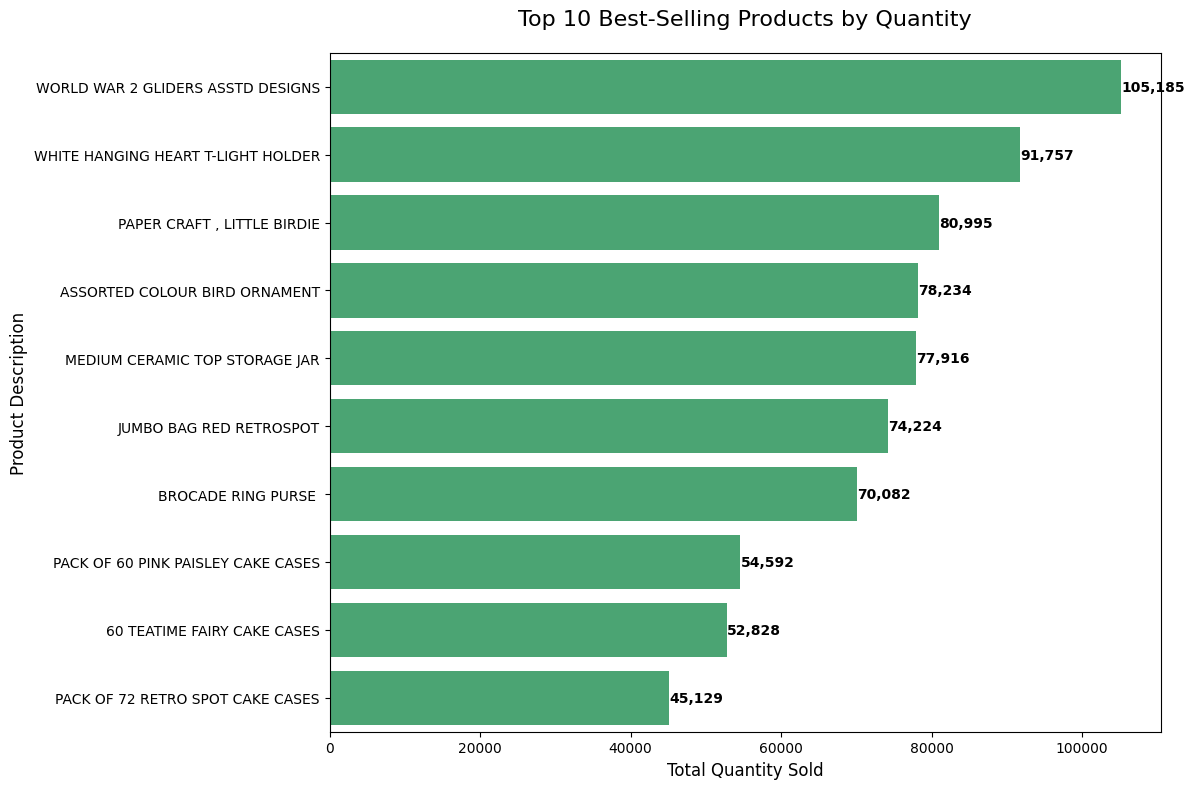

In [41]:
# --- Top 10 Best-Selling Products Analysis ---

# Group by product description and sum quantities
top_products = df.groupby('description')['quantity'].sum().sort_values(ascending=False).head(10)

print("Top 10 Best-Selling Products (by quantity):")
print(top_products)

# --- Visualize the results ---
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with single color
sns.barplot(x=top_products.values, 
            y=top_products.index,
            color='mediumseagreen')  # Using single color instead of palette

# Customize the visualization
plt.title('Top 10 Best-Selling Products by Quantity', fontsize=16, pad=20)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Product Description', fontsize=12)

# Add value labels on the bars
for i, v in enumerate(top_products.values):
    plt.text(v, i, f'{v:,.0f}', 
             va='center',
             fontsize=10,
             fontweight='bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Explanation:
- `df.groupby('description')['quantity'].sum()` aggregates the total quantity sold for each product.  
- `.sort_values(ascending=False).head(10)` selects the **top 10 products** with the highest sales quantity.  
- The bar plot (`sns.barplot`) visualizes these best-selling products, making it easy to compare them at a glance.  
- This step provides actionable insights into which products are most popular and may influence stock management or promotional decisions.

### Inspecting Column Names

After cleaning and preprocessing the dataset, it's useful to check the column names.  
This helps us confirm the structure of the DataFrame and plan further analysis steps.

In [15]:
print(df.columns)

Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country', 'revenue'],
      dtype='object')


### Explanation:
- `df.columns` lists all column names in the DataFrame.  
- Printing the column names allows us to verify that all expected columns are present and correctly named.  
- This step is helpful before performing operations like grouping, aggregations, or feature engineering.

### Analysis – UK vs. Rest-of-World Revenue

To understand the geographical distribution of revenue, we calculate the total revenue generated by the UK compared to the rest of the world.  
This helps identify which regions contribute most to the overall sales.

In [16]:
# --- UK vs. Rest-of-World Revenue Percentage ---
uk_revenue = df[df['country'] == 'United Kingdom']['revenue'].sum()
non_uk_revenue = df[df['country'] != 'United Kingdom']['revenue'].sum()
total_revenue = df['revenue'].sum()

uk_pct = uk_revenue / total_revenue * 100
non_uk_pct = non_uk_revenue / total_revenue * 100

print(f"UK Revenue: £{uk_revenue:,.2f} ({uk_pct:.1f}%)")
print(f"Rest of World Revenue: £{non_uk_revenue:,.2f} ({non_uk_pct:.1f}%)")

UK Revenue: £14,389,234.92 (82.8%)
Rest of World Revenue: £2,985,569.35 (17.2%)


### Explanation:
- `df[df['country'] == 'United Kingdom']['revenue'].sum()` calculates the total revenue from UK customers.  
- `df[df['country'] != 'United Kingdom']['revenue'].sum()` calculates the revenue from all other countries.  
- `total_revenue` is the sum of all revenues in the dataset.  
- `uk_pct` and `non_uk_pct` compute the percentage contribution of each region.  
- Printing these values gives a clear picture of how much the UK contributes to overall sales versus the rest of the world, which can guide regional marketing or expansion strategies.

### Analysis – Top 10 Products by Total Revenue

To understand which products generate the most revenue, we calculate the total revenue per product.  
This helps identify the highest-earning products, which can guide pricing, marketing, and inventory strategies.

In [17]:
# --- Top 10 Products by Total Revenue ---
top_products_revenue = (
    df.groupby('description')['revenue']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print("\nTop 10 Best-Selling Products (by total revenue):")
print(top_products_revenue)


Top 10 Best-Selling Products (by total revenue):
description
REGENCY CAKESTAND 3 TIER              277656.25
WHITE HANGING HEART T-LIGHT HOLDER    247048.01
PAPER CRAFT , LITTLE BIRDIE           168469.60
Manual                                151777.67
JUMBO BAG RED RETROSPOT               134307.44
POSTAGE                               124648.04
ASSORTED COLOUR BIRD ORNAMENT         124351.86
PARTY BUNTING                         103283.38
MEDIUM CERAMIC TOP STORAGE JAR         81416.73
PAPER CHAIN KIT 50'S CHRISTMAS         76598.18
Name: revenue, dtype: float64


### Explanation:
- `df.groupby('description')['revenue'].sum()` aggregates the total revenue for each product.  
- `.sort_values(ascending=False).head(10)` selects the **top 10 products** that generate the highest revenue.  
- Printing this list shows which products contribute most to overall sales.  
- This analysis provides actionable insights for prioritizing marketing, inventory management, and product promotions.

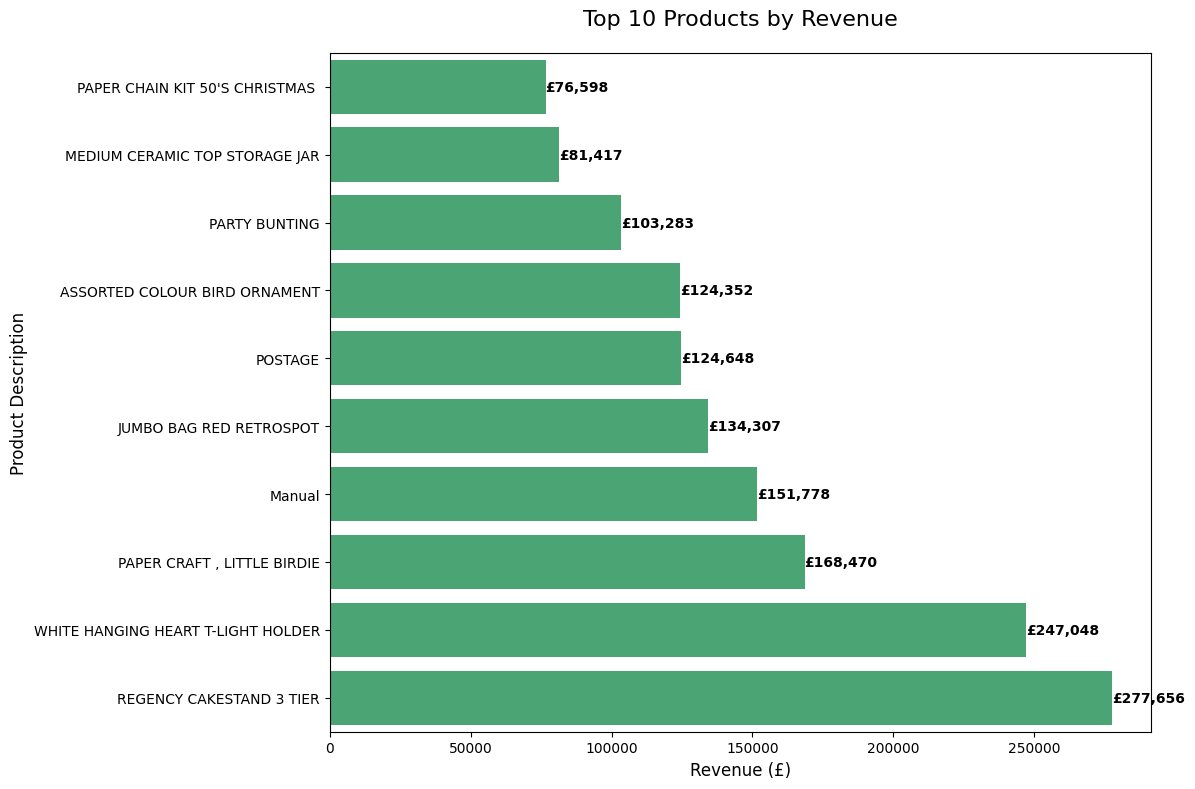


Top 10 Best-Selling Products (by total revenue):
PAPER CHAIN KIT 50'S CHRISTMAS : £76,598.18
MEDIUM CERAMIC TOP STORAGE JAR: £81,416.73
PARTY BUNTING: £103,283.38
ASSORTED COLOUR BIRD ORNAMENT: £124,351.86
POSTAGE: £124,648.04
JUMBO BAG RED RETROSPOT: £134,307.44
Manual: £151,777.67
PAPER CRAFT , LITTLE BIRDIE: £168,469.60
WHITE HANGING HEART T-LIGHT HOLDER: £247,048.01
REGENCY CAKESTAND 3 TIER: £277,656.25


In [18]:
# Top 10 Products by Total Revenue Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded with revenue column
# Create the revenue analysis
top_products_revenue = (
    df.groupby('description')['revenue']
    .sum()
    .sort_values(ascending=True)  # Ascending for horizontal bar chart
    .tail(10)  # Get top 10
)

# Create figure with larger size for better readability
plt.figure(figsize=(12, 8))

# Create horizontal bar chart
sns.barplot(x=top_products_revenue.values, 
            y=top_products_revenue.index,
            color='mediumseagreen')

# Customize the chart
plt.title('Top 10 Products by Revenue', fontsize=16, pad=20)
plt.xlabel('Revenue (£)', fontsize=12)
plt.ylabel('Product Description', fontsize=12)

# Add revenue values on the bars
for i, v in enumerate(top_products_revenue.values):
    plt.text(v, i, f'£{v:,.0f}', 
             va='center',
             fontsize=10,
             fontweight='bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Display the plot
plt.show()

# Print the numerical values
print("\nTop 10 Best-Selling Products (by total revenue):")
for product, revenue in top_products_revenue.items():
    print(f"{product}: £{revenue:,.2f}")

### Explanation:
- `df.groupby('description')['revenue'].sum()` aggregates the total revenue for each product.  
- `.sort_values(ascending=False).head(10)` selects the **top 10 products** that generate the highest revenue.  
- Printing this list shows which products contribute most to overall sales.  
- This analysis provides actionable insights for prioritizing marketing, inventory management, and product promotions.

### Analysis – Comparing Top 10 by Quantity vs. Revenue

Sometimes the products that sell the most units are not the ones that generate the most revenue.  
By comparing the **Top 10 by Quantity** with the **Top 10 by Revenue**, we can identify products that are either:
- **High sales volume but low revenue** (cheap, popular items).
- **Low sales volume but high revenue** (premium, high-value items).

In [19]:
# --- Compare Top 10 by Quantity vs. Revenue ---
top_products_quantity = df.groupby('description')['quantity'].sum().sort_values(ascending=False).head(10)

print("\nProducts in Top 10 by Quantity but NOT by Revenue:")
print(set(top_products_quantity.index) - set(top_products_revenue.index))

print("\nProducts in Top 10 by Revenue but NOT by Quantity:")
print(set(top_products_revenue.index) - set(top_products_quantity.index))


Products in Top 10 by Quantity but NOT by Revenue:
{'PACK OF 60 PINK PAISLEY CAKE CASES', 'WORLD WAR 2 GLIDERS ASSTD DESIGNS', 'PACK OF 72 RETRO SPOT CAKE CASES', 'BROCADE RING PURSE ', '60 TEATIME FAIRY CAKE CASES'}

Products in Top 10 by Revenue but NOT by Quantity:
{'POSTAGE', 'REGENCY CAKESTAND 3 TIER', 'Manual', 'PARTY BUNTING', "PAPER CHAIN KIT 50'S CHRISTMAS "}


### Explanation:
- The first comparison (`set(top_products_quantity.index) - set(top_products_revenue.index)`)  
  shows items that sell in high quantities but don’t make it into the top revenue list.  
- The second comparison (`set(top_products_revenue.index) - set(top_products_quantity.index)`)  
  highlights items that don’t sell as many units but generate significant revenue.  
- This helps businesses decide whether to focus on **popular low-cost items** or **premium high-margin products**.

### Analysis – Geographic Revenue Distribution

Understanding where revenue comes from geographically helps identify key markets.  
Here we calculate total revenue by **country**, visualize the **Top 10 countries**,  
and also display their percentage contribution to overall sales.

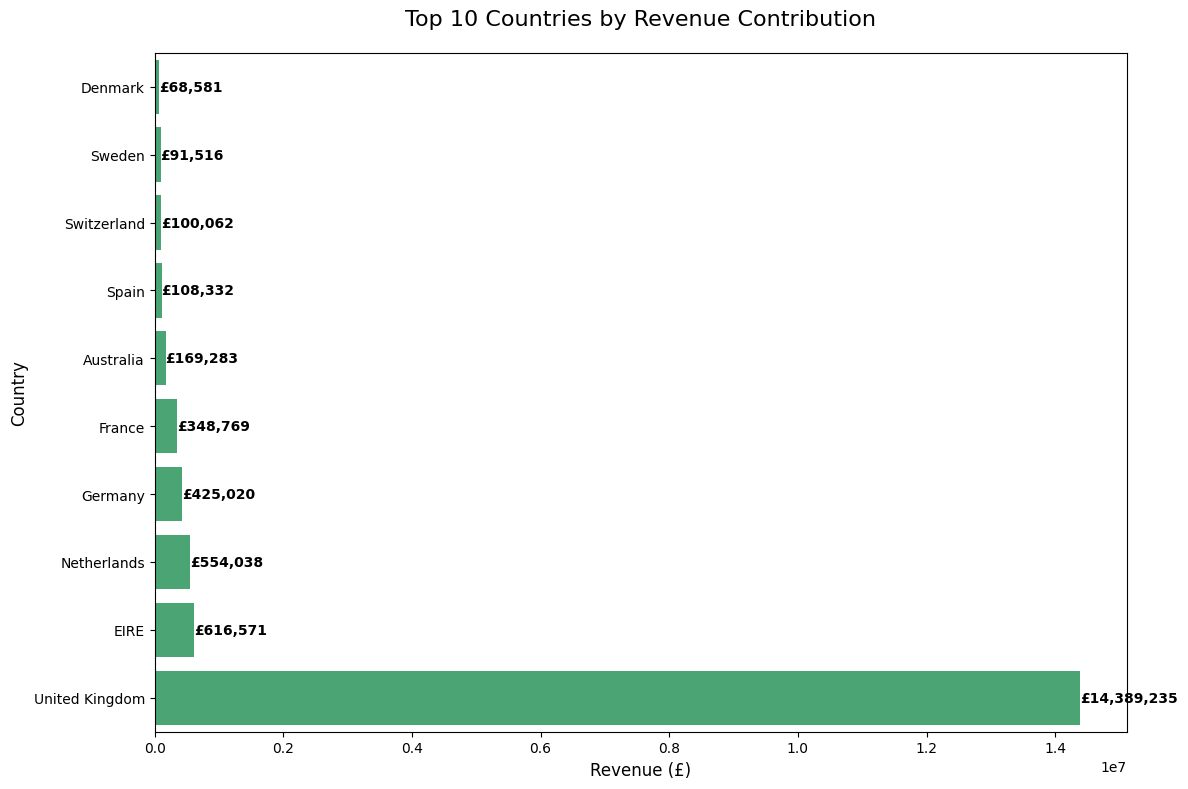


Revenue Contribution by Country:
Denmark: £68,580.69 (0.4%)
Sweden: £91,515.82 (0.5%)
Switzerland: £100,061.94 (0.6%)
Spain: £108,332.49 (0.6%)
Australia: £169,283.46 (1.0%)
France: £348,768.96 (2.0%)
Germany: £425,019.71 (2.4%)
Netherlands: £554,038.09 (3.2%)
EIRE: £616,570.54 (3.5%)
United Kingdom: £14,389,234.92 (82.8%)


In [20]:
# Geographic Revenue Analysis with Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate revenue by country
country_revenue = df.groupby('country')['revenue'].sum().sort_values(ascending=True)

# Get top 10 countries
top_10_countries = country_revenue.tail(10)  # Using tail since we'll plot ascending

# Create a figure with larger size
plt.figure(figsize=(12, 8))

# Create bar chart with single color to avoid FutureWarning
sns.barplot(x=top_10_countries.values, 
            y=top_10_countries.index,
            color='mediumseagreen')  # use 'color' instead of 'palette'

# Add title and labels with improved formatting
plt.title('Top 10 Countries by Revenue Contribution', fontsize=16, pad=20)
plt.xlabel('Revenue (£)', fontsize=12)
plt.ylabel('Country', fontsize=12)

# Add revenue values on the bars
for i, v in enumerate(top_10_countries.values):
    plt.text(v, i, f'£{v:,.0f}', 
             va='center', 
             fontsize=10,
             fontweight='bold')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print percentage contribution
print("\nRevenue Contribution by Country:")
for country, rev in top_10_countries.items():
    percentage = (rev / country_revenue.sum()) * 100
    print(f"{country}: £{rev:,.2f} ({percentage:.1f}%)")

### Explanation:

- We first group sales by `country` and calculate the total revenue for each country.  
- `top_10_countries = country_revenue.tail(10)` extracts the top 10 countries by revenue.  
- A horizontal bar chart visualizes these top contributors, making it easy to compare their revenue.  
- Revenue values are displayed on the bars for clarity.  
- The percentage contribution calculation shows the relative importance of each country to overall sales.  
- This analysis helps businesses focus marketing, logistics, and customer service on the **most profitable regions**.

### Analysis – Monthly Sales Trend

Time series analysis helps identify **seasonality, growth, or decline** in sales.  
Here we aggregate revenue by **month** to observe overall trends.

Total Revenue per Month:
invoicedate
2009-12-31     683504.010
2010-01-31     555802.672
2010-02-28     504558.956
2010-03-31     696978.471
2010-04-30     591982.002
2010-05-31     597833.380
2010-06-30     636371.130
2010-07-31     589736.170
2010-08-31     602224.600
2010-09-30     829013.951
2010-10-31    1033112.010
2010-11-30    1166460.022
2010-12-31     570422.730
2011-01-31     568101.310
2011-02-28     446084.920
2011-03-31     594081.760
2011-04-30     468374.331
2011-05-31     677355.150
2011-06-30     660046.050
2011-07-31     598962.901
2011-08-31     644051.040
2011-09-30     950690.202
2011-10-31    1035642.450
2011-11-30    1156205.610
2011-12-31     517208.440
Freq: ME, Name: revenue, dtype: float64


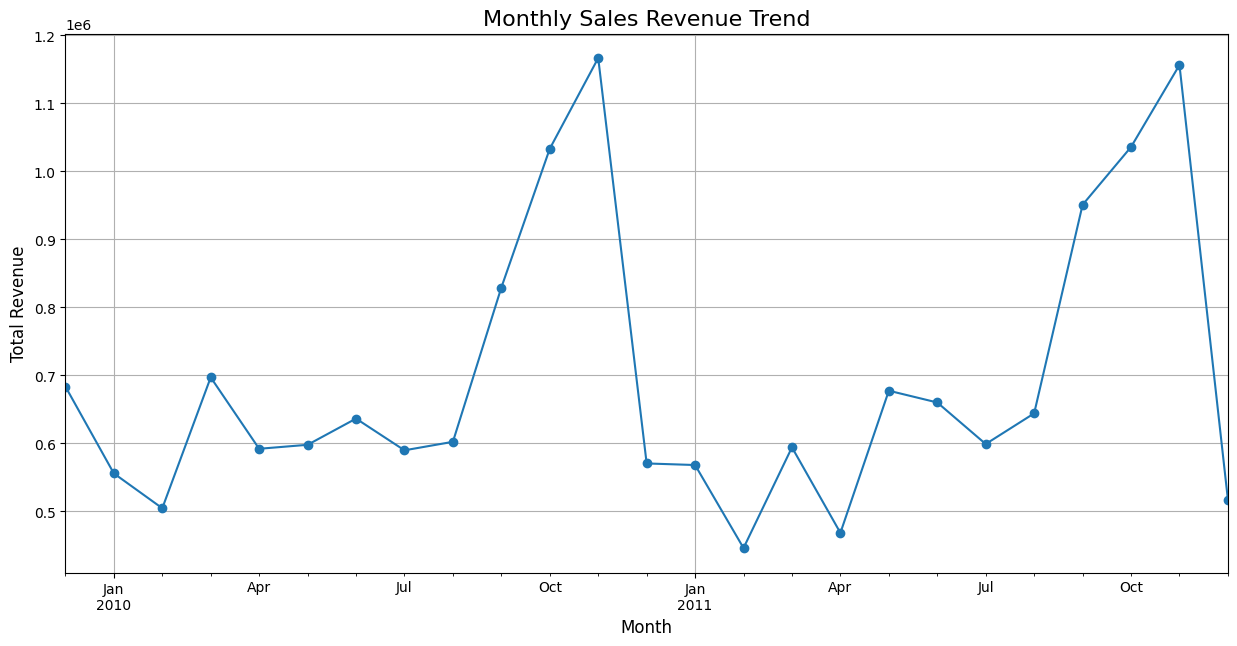

In [21]:
# --- 3. Monthly Sales Trend ---

# To analyze trends over time, we'll set 'invoicedate' as the DataFrame index.
df_time_series = df.set_index('invoicedate')

# Resample the data by month ('ME' stands for Month-End) and sum the revenue for each month.
monthly_revenue = df_time_series['revenue'].resample('ME').sum()

print("Total Revenue per Month:")
print(monthly_revenue)

# --- Visualize the trend ---
plt.figure(figsize=(15, 7))
monthly_revenue.plot(kind='line', marker='o', linestyle='-')
plt.title('Monthly Sales Revenue Trend', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Revenue', fontsize=12)
plt.grid(True)
plt.show()

### Explanation:
- We convert `invoicedate` into the DataFrame index to allow time-based resampling.  
- Using `.resample('ME').sum()`, monthly revenue is aggregated at **month-end intervals**.  
- The line chart clearly shows peaks and troughs, which can indicate:  
  - **Seasonal demand patterns** (e.g., holidays, special events).  
  - **Long-term growth or decline** trends.  
  - Periods of unusually high or low sales that may need investigation.  

This insight helps in **inventory planning, marketing campaigns, and forecasting** future demand.

### Analysis – Time-Based Sales Patterns

Understanding when customers purchase can help optimize **marketing campaigns, staffing, and promotions**.  
Here, we analyze revenue patterns by **day of the week** and **hour of the day**.

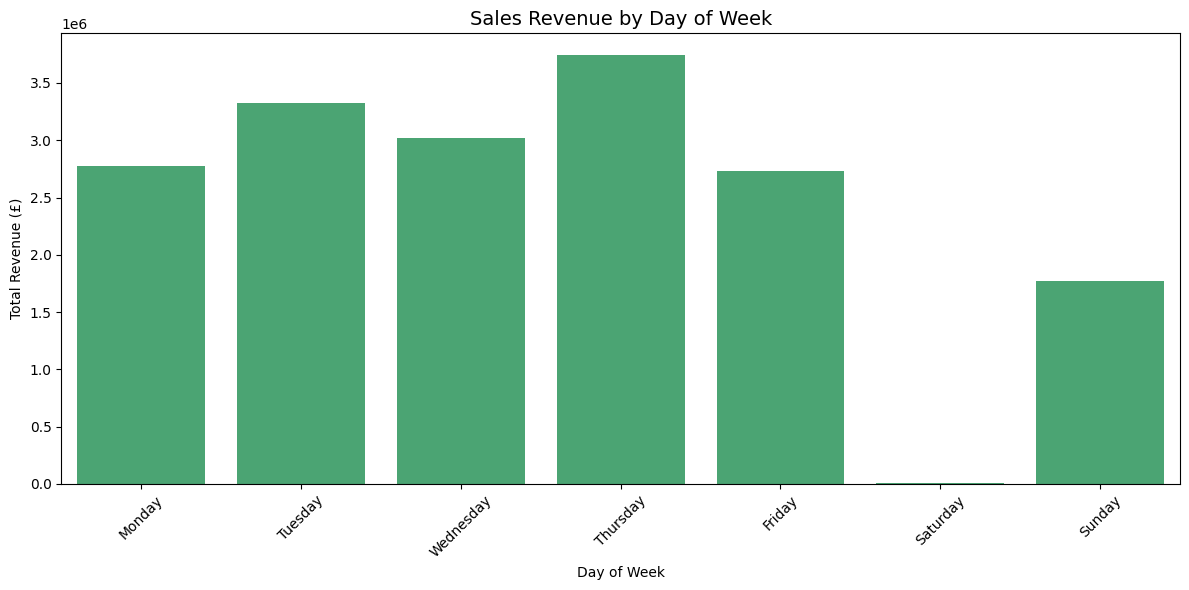

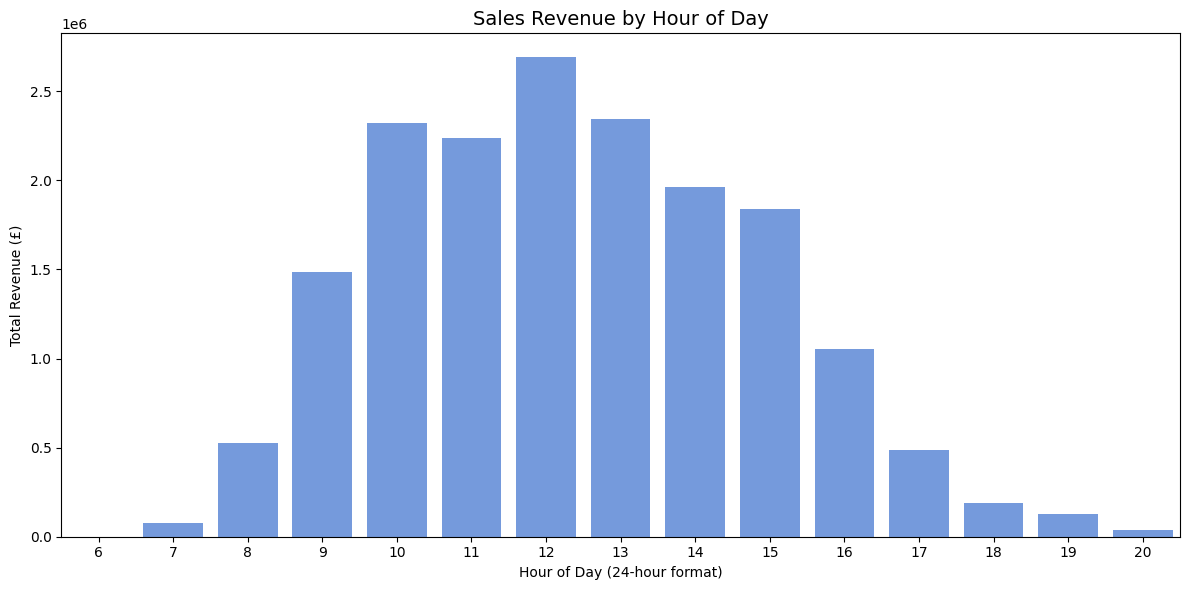

In [37]:
# Time-based Analysis: Day of Week & Hour of Day
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('Data/online_retail_cleaned.csv', parse_dates=['invoicedate'])
df['revenue'] = df['quantity'] * df['price']

# Extract day of week and hour
df['DayOfWeek'] = df['invoicedate'].dt.day_name()
df['HourOfDay'] = df['invoicedate'].dt.hour

# -----------------------------
# 1. Day of Week Analysis
# -----------------------------
plt.figure(figsize=(12, 6))
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = df.groupby('DayOfWeek')['revenue'].sum().reindex(day_order)

# Fixed Seaborn warning: use color instead of palette (single color)
sns.barplot(x=daily_sales.index, y=daily_sales.values, color='mediumseagreen')

plt.title('Sales Revenue by Day of Week', fontsize=14)
plt.xlabel('Day of Week')
plt.ylabel('Total Revenue (£)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# -----------------------------
# 2. Hour of Day Analysis
# -----------------------------
plt.figure(figsize=(12, 6))
hourly_sales = df.groupby('HourOfDay')['revenue'].sum()

# Fixed Seaborn warning: use color instead of palette (single color)
sns.barplot(x=hourly_sales.index, y=hourly_sales.values, color='cornflowerblue')

plt.title('Sales Revenue by Hour of Day', fontsize=14)
plt.xlabel('Hour of Day (24-hour format)')
plt.ylabel('Total Revenue (£)')
plt.tight_layout()
plt.show()

### Explanation:

- We extract the day of the week (`DayOfWeek`) and hour of the day (`HourOfDay`) from `invoicedate`.  
- `daily_sales = df.groupby('DayOfWeek')['revenue'].sum()` calculates total revenue for each day of the week, and the bar chart visualizes which days generate the most sales.  
- `hourly_sales = df.groupby('HourOfDay')['revenue'].sum()` calculates total revenue for each hour, showing peak sales hours in the day.  
- These visualizations help identify **when customers are most active**, which is useful for **staffing, marketing campaigns, and promotions timing**.

### Analysis – Top 10 Most Valuable Customers

Identifying high-value customers helps focus **loyalty programs, personalized marketing, and retention strategies**.  
Here, we calculate the total revenue generated by each customer and visualize the top 10 contributors.

Top 10 Most Valuable Customers (by total revenue):
customer_id
18102    580987.04
14646    528602.52
14156    313437.62
14911    291420.81
17450    244784.25
13694    195640.69
17511    172132.87
16446    168472.50
16684    147142.77
12415    144458.37
Name: revenue, dtype: float64


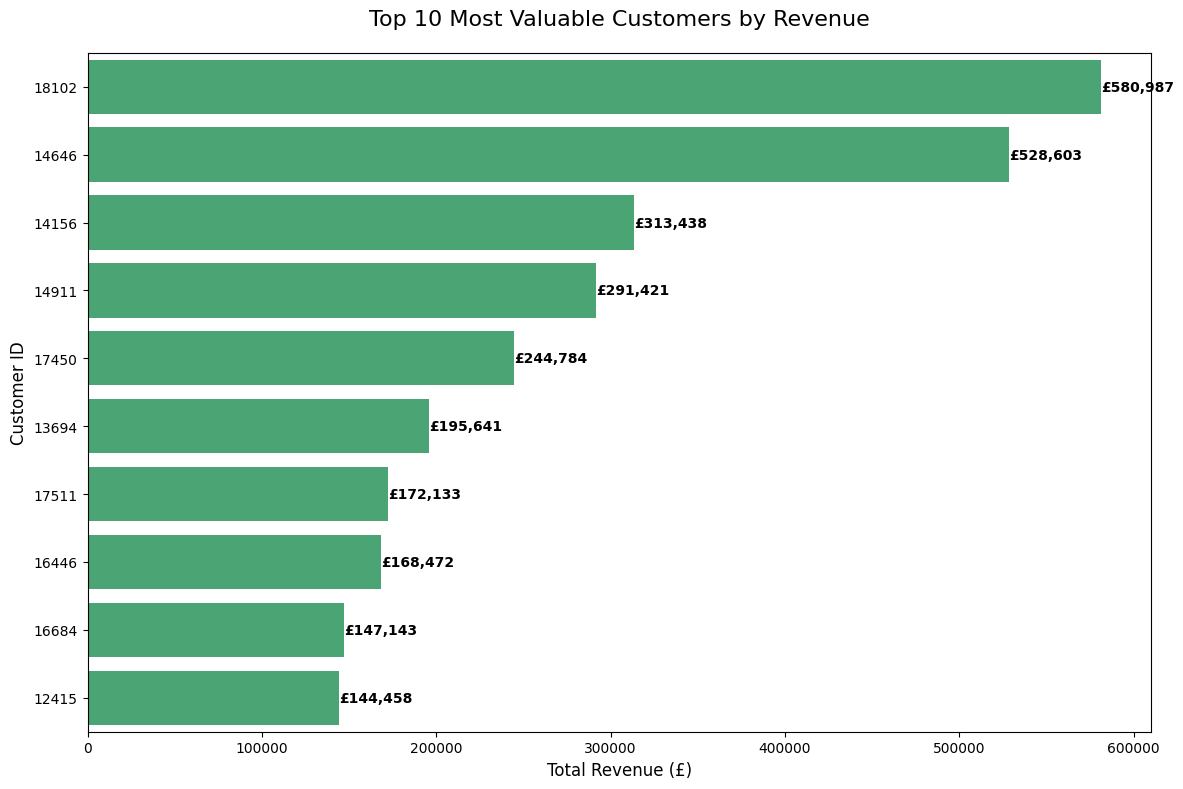

In [38]:
# --- Top 10 Most Valuable Customers Analysis ---

# Group by customer ID and sum the revenue
top_customers = df.groupby('customer_id')['revenue'].sum().sort_values(ascending=False).head(10)

print("Top 10 Most Valuable Customers (by total revenue):")
print(top_customers)

# --- Visualize the results ---
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with single color
sns.barplot(x=top_customers.values, 
            y=top_customers.index.astype(str),
            color='mediumseagreen',  # Using single color instead of palette
            orient='h')

# Customize the visualization
plt.title('Top 10 Most Valuable Customers by Revenue', fontsize=16, pad=20)
plt.xlabel('Total Revenue (£)', fontsize=12)
plt.ylabel('Customer ID', fontsize=12)

# Add value labels on the bars
for i, v in enumerate(top_customers.values):
    plt.text(v, i, f'£{v:,.0f}', 
             va='center',
             fontsize=10,
             fontweight='bold')

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

### Explanation:
- `df.groupby('customer_id')['revenue'].sum()` aggregates total revenue per customer.  
- `.sort_values(ascending=False).head(10)` selects the **top 10 highest-spending customers**.  
- The horizontal bar chart visualizes their contribution to total revenue, making it easy to identify **key customers** at a glance.  
- Businesses can use this insight to develop **targeted marketing campaigns, loyalty programs, and personalized offers** for these valuable customers.

## Phase 3: Advanced Analytics - RFM Customer Segmentation
### RFM Analysis

RFM analysis helps understand customer behavior by measuring recency, frequency, and monetary value.  
Recency shows how many days have passed since a customer's last purchase, frequency counts the number of unique purchases, and monetary value sums the total revenue from each customer.  
This information is useful to identify loyal customers, high spenders, and potential wholesalers.


In [26]:
# --- RFM Analysis ---
import datetime as dt
snapshot_date = df['invoicedate'].max() + dt.timedelta(days=1)

rfm_data = df.groupby('customer_id').agg({
    'invoicedate': lambda date: (snapshot_date - date.max()).days,  # Recency
    'invoice': 'nunique',                                           # Frequency
    'revenue': 'sum'                                                # Monetary
})

rfm_data.rename(columns={'invoicedate': 'Recency',
                         'invoice': 'Frequency',
                         'revenue': 'MonetaryValue'}, inplace=True)

### Explanation:
- **Recency**: Calculated as the number of days since the customer's last purchase (`snapshot_date - last_invoice`).  
- **Frequency**: Number of unique invoices per customer, indicating purchase frequency.  
- **Monetary Value**: Total revenue contributed by the customer.  
- Renaming columns improves readability (`Recency`, `Frequency`, `MonetaryValue`).  
- This RFM table is the foundation for **segmenting customers** into groups like champions, loyal, or at-risk customers, enabling **targeted marketing**.

### Creating RFM Scores Using Quintiles

RFM scores help segment customers based on purchasing behavior.  
We assign scores from 1 to 5 for each metric: Recency (R), Frequency (F), and MonetaryValue (M).  
A higher R score means the customer purchased more recently, a higher F score indicates more frequent purchases, and a higher M score reflects higher spending.

In [27]:
# --- Create RFM Scores using Quintiles (1–5) ---
r_labels = range(5, 0, -1)  # 5 = most recent
f_labels = range(1, 6)      # 5 = most frequent
m_labels = range(1, 6)      # 5 = highest monetary value

rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=5, labels=r_labels, duplicates='drop')
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=5, labels=f_labels)
rfm_data['M_Score'] = pd.qcut(rfm_data['MonetaryValue'], q=5, labels=m_labels, duplicates='drop')

# --- Combine scores into a single RFM score ---
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + \
                        rfm_data['F_Score'].astype(str) + \
                        rfm_data['M_Score'].astype(str)

### Explanation:

- Each customer is assigned a score from 1 to 5 for **Recency (R), Frequency (F), and MonetaryValue (M)** using quintiles.  
- A higher **R score** means the customer purchased more recently.  
- A higher **F score** indicates more frequent purchases.  
- A higher **M score** reflects higher spending.  
- The combined **RFM_Score** provides a single metric to quickly identify **high-value, loyal, and potentially inactive customers**, useful for segmentation, targeted marketing, and retention strategies.


### RFM Analysis – Recency, Frequency, Monetary Calculation

To understand customer behavior, we calculate **RFM metrics**:  
- **Recency (R):** Days since the customer's last purchase.  
- **Frequency (F):** Number of unique purchases/invoices.  
- **Monetary Value (M):** Total revenue generated by the customer.  

We define a **snapshot date** as the day after the last transaction in the dataset  
to calculate Recency accurately.

In [28]:
# --- RFM Analysis ---
#Phase 4
# To calculate Recency, we need a 'snapshot' date. We'll use the day after the last transaction date in our dataset.
import datetime as dt
snapshot_date = df['invoicedate'].max() + dt.timedelta(days=1)

# Calculate Recency, Frequency, and Monetary values for each customer
rfm_data = df.groupby('customer_id').agg({
    'invoicedate': lambda date: (snapshot_date - date.max()).days,  # Recency: days since last purchase
    'invoice': 'nunique',                                           # Frequency: count of unique invoices
    'revenue': 'sum'                                                # Monetary: total revenue
})

# Rename the columns to be more descriptive
rfm_data.rename(columns={'invoicedate': 'Recency',
                         'invoice': 'Frequency',
                         'revenue': 'MonetaryValue'}, inplace=True)

print("RFM Data Calculated:")
rfm_data.head()

RFM Data Calculated:


,Recency,Frequency,MonetaryValue
customer_id,,,
12346,326,12,77556.46
12347,2,8,4921.53
12348,75,5,2019.40
12349,19,4,4428.69
12350,310,1,334.40


### Explanation:
- We use a **snapshot date** to compute Recency as the number of days since the last purchase.  
- `invoice.nunique()` counts **unique invoices** to measure how often each customer buys.  
- `revenue.sum()` calculates the total revenue contributed by each customer.  
- The resulting `rfm_data` DataFrame contains **Recency, Frequency, and MonetaryValue** for every customer,  
  forming the foundation for subsequent RFM scoring and segmentation.

### RFM Analysis – Creating RFM Scores

RFM analysis helps us understand customer value by evaluating **Recency, Frequency, and Monetary value**.  
We calculate scores for each metric and combine them into a single `RFM_Score`, which can be used to segment customers for targeted marketing and loyalty strategies.

In [29]:
# --- Create RFM Scores ---

# Create labels for the scores (1=worst, 4=best)
r_labels = range(4, 0, -1) # For Recency, lower is better, so we reverse the labels
f_labels = range(1, 5)    # For Frequency, higher is better
m_labels = range(1, 5)    # For Monetary, higher is better

# Use qcut with rank(method='first') for Frequency to handle the large number of one-time buyers,
# and duplicates='drop' for Recency and Monetary to handle other non-unique bin edges.
rfm_data['R_Score'] = pd.qcut(rfm_data['Recency'], q=4, labels=r_labels, duplicates='drop')
rfm_data['F_Score'] = pd.qcut(rfm_data['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm_data['M_Score'] = pd.qcut(rfm_data['MonetaryValue'], q=4, labels=m_labels, duplicates='drop')


# --- Combine scores into a single RFM score ---
# This makes it easy to create segments
rfm_data['RFM_Score'] = rfm_data['R_Score'].astype(str) + rfm_data['F_Score'].astype(str) + rfm_data['M_Score'].astype(str)

print("RFM Scores Calculated:")
rfm_data.head()

RFM Scores Calculated:


,Recency,Frequency,MonetaryValue,R_Score,F_Score,M_Score,RFM_Score
customer_id,,,,,,,
12346,326,12,77556.46,2,4,4,244
12347,2,8,4921.53,4,4,4,444
12348,75,5,2019.40,3,3,3,333
12349,19,4,4428.69,4,3,4,434
12350,310,1,334.40,2,1,1,211


### Explanation:
- We assign each customer a **score from 1 to 4** for Recency, Frequency, and Monetary metrics.  
- **Recency:** Lower number of days since last purchase gets a higher score (more recent = better).  
- **Frequency:** More frequent buyers receive a higher score.  
- **Monetary:** Customers with higher total spending get a higher score.  
- Combining these scores into a single `RFM_Score` (e.g., "443") allows us to segment customers and target marketing or loyalty strategies effectively.

### RFM Analysis – Customer Segmentation

After calculating RFM scores, we can classify customers into meaningful segments, such as **Champions, Loyal Customers, Potential Loyalists, New Customers, At-Risk Customers, Hibernating, and Needs Attention**.  
This helps in designing targeted marketing campaigns and loyalty programs.

Customer Segments Created:
             Recency  Frequency  MonetaryValue R_Score F_Score M_Score  \
customer_id                                                              
12346            326         12       77556.46       2       4       4   
12347              2          8        4921.53       4       4       4   
12348             75          5        2019.40       3       3       3   
12349             19          4        4428.69       4       3       4   
12350            310          1         334.40       2       1       1   

            RFM_Score              Segment  
customer_id                                 
12346             244    At-Risk Customers  
12347             444            Champions  
12348             333  Potential Loyalists  
12349             434            Champions  
12350             211          Hibernating  


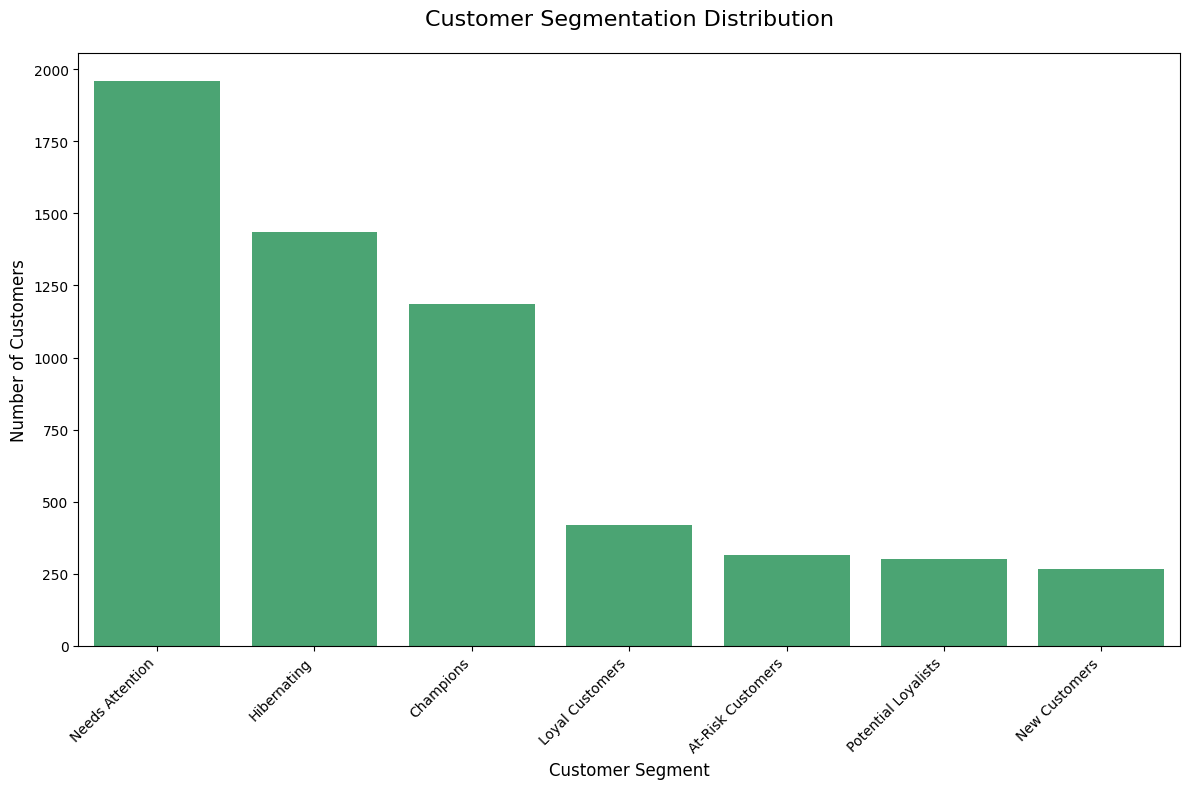

In [30]:
# --- Create Customer Segments from RFM Scores ---

def rfm_segment(df):
    """Map RFM scores to customer segments"""
    if df['RFM_Score'] in ['444', '443', '434', '344']:
        return 'Champions'
    elif df['RFM_Score'] in ['343', '334', '342', '433']:
        return 'Loyal Customers'
    elif df['RFM_Score'] in ['424', '423', '333', '324']:
        return 'Potential Loyalists'
    elif df['RFM_Score'] in ['411', '412', '421', '422']:
        return 'New Customers'
    elif df['RFM_Score'] in ['244', '243', '234', '144', '143', '134']:
        return 'At-Risk Customers'
    elif df['RFM_Score'] in ['111', '112', '121', '122', '211', '212']:
        return 'Hibernating'
    else:
        return 'Needs Attention'

# Apply segmentation
rfm_data['Segment'] = rfm_data.apply(rfm_segment, axis=1)

print("Customer Segments Created:")
print(rfm_data.head())

# --- Visualize segment distribution ---
segment_counts = rfm_data['Segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Count']

plt.figure(figsize=(12, 8))
sns.barplot(data=segment_counts, 
            x='Segment', 
            y='Count',
            color='mediumseagreen')  # Using a single color instead of palette

plt.title('Customer Segmentation Distribution', fontsize=16, pad=20)
plt.xlabel('Customer Segment', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Improved readability for labels
plt.tight_layout()  # Prevent label cutoff
plt.show()

### Explanation:
- The `rfm_segment` function maps each RFM score combination to a **customer segment** based on purchasing behavior.  
- Applying this function creates a new column `Segment` in the RFM dataframe.  
- The bar chart visualizes the **distribution of customers across segments**, highlighting the proportion of high-value versus at-risk customers.  
- This segmentation helps businesses **target marketing efforts, retention strategies, and loyalty programs** effectively.

## Phase 4: Strategic Recommendations
### Wholesaler Hypothesis Analysis

To understand customer purchasing behavior, we investigate whether certain customers are likely **wholesalers**.  
We analyze total spending per customer and compare **high-spending customers** against regular retail buyers.  
Visualizations and summary statistics help identify **potential wholesalers** and their buying patterns.

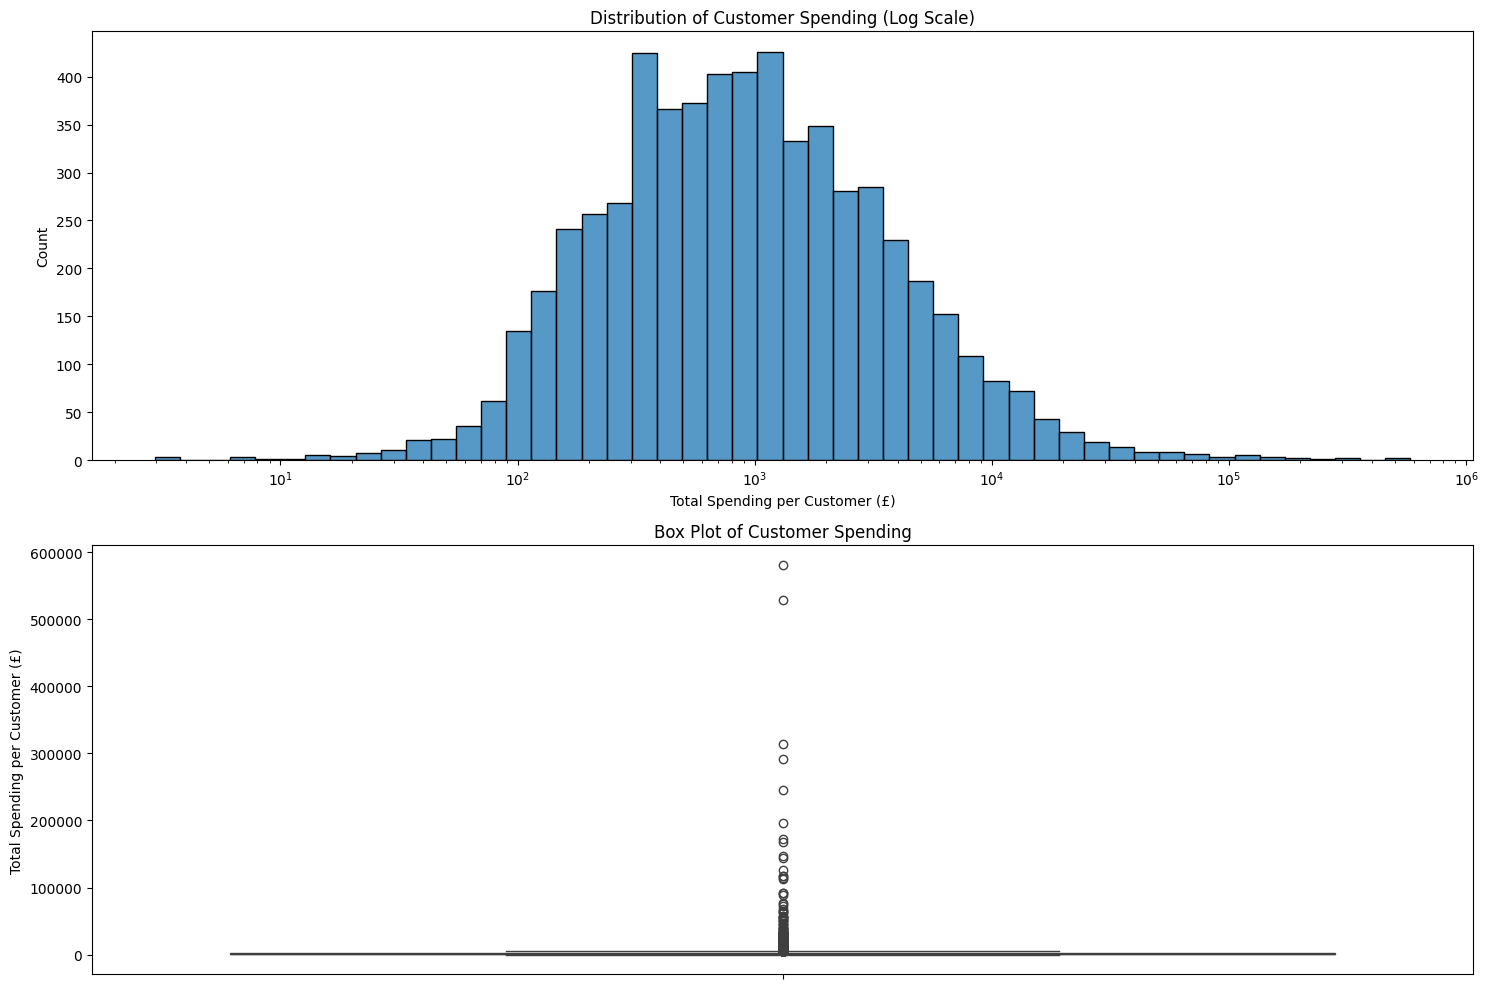


Wholesaler Analysis Results:
Average customer spending: £2,955.90
Median customer spending: £867.74
90th percentile spending: £5,465.74
Number of potential wholesalers: 588

Comparison of Average Quantity per Transaction:
Average quantity for regular customers: 8.66
Average quantity for potential wholesalers: 19.55


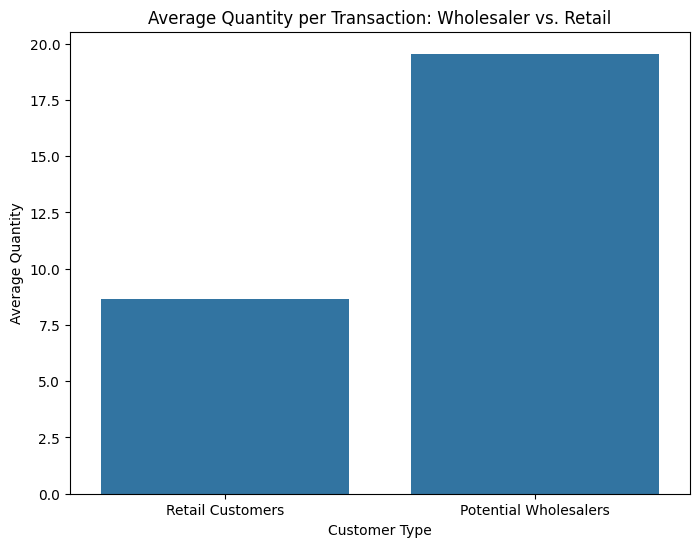

In [31]:
# Phase 4
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_wholesaler_hypothesis(df):
    """Analyze customer spending patterns to identify wholesalers vs retail customers"""

    # Calculate total monetary value per customer
    customer_monetary = df.groupby('customer_id')['revenue'].sum()

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # 1. Histogram of monetary values
    plt.subplot(2, 1, 1)
    sns.histplot(customer_monetary, bins=50, log_scale=True)
    plt.title('Distribution of Customer Spending (Log Scale)')
    plt.xlabel('Total Spending per Customer (£)')
    plt.ylabel('Count')

    # 2. Box plot
    plt.subplot(2, 1, 2)
    sns.boxplot(y=customer_monetary)
    plt.title('Box Plot of Customer Spending')
    plt.ylabel('Total Spending per Customer (£)')

    plt.tight_layout()
    plt.show()

    # Calculate statistics
    stats = {
        'mean_spending': customer_monetary.mean(),
        'median_spending': customer_monetary.median(),
        'spending_90th_percentile': customer_monetary.quantile(0.9),
        'potential_wholesalers': (customer_monetary > customer_monetary.quantile(0.9)).sum()
    }

    return stats, customer_monetary

# Load and prepare data
df = pd.read_csv('Data/online_retail_cleaned.csv', parse_dates=['invoicedate'])
df['revenue'] = df['quantity'] * df['price']

# Run analysis
stats, customer_monetary = analyze_wholesaler_hypothesis(df)

# Print findings
print("\nWholesaler Analysis Results:")
print(f"Average customer spending: £{stats['mean_spending']:,.2f}")
print(f"Median customer spending: £{stats['median_spending']:,.2f}")
print(f"90th percentile spending: £{stats['spending_90th_percentile']:,.2f}")
print(f"Number of potential wholesalers: {stats['potential_wholesalers']}")

# --- Further Analysis: Compare Wholesaler vs. Retail Behavior ---

# Create a boolean flag to identify wholesalers in the main DataFrame
wholesaler_threshold = customer_monetary.quantile(0.9)
df['is_wholesaler'] = df['customer_id'].isin(customer_monetary[customer_monetary > wholesaler_threshold].index)

# Compare the average quantity per transaction line
avg_quantity_comparison = df.groupby('is_wholesaler')['quantity'].mean()

print("\nComparison of Average Quantity per Transaction:")
print(f"Average quantity for regular customers: {avg_quantity_comparison[False]:.2f}")
print(f"Average quantity for potential wholesalers: {avg_quantity_comparison[True]:.2f}")

# Visualize the comparison
plt.figure(figsize=(8, 6))
sns.barplot(x=avg_quantity_comparison.index, y=avg_quantity_comparison.values)
plt.title('Average Quantity per Transaction: Wholesaler vs. Retail')
plt.ylabel('Average Quantity')
plt.xlabel('Customer Type')
plt.xticks([0, 1], ['Retail Customers', 'Potential Wholesalers'])
plt.show()

### Explanation:

- This analysis investigates the **Wholesaler Hypothesis**, i.e., whether some customers are **high-volume buyers** (potential wholesalers) compared to regular retail customers.  
- We first calculate **total revenue per customer** and visualize it using a **histogram** (log scale) and a **box plot** to identify the distribution and outliers.  
- Key statistics such as **mean, median, 90th percentile**, and the **number of potential wholesalers** (top 10% spenders) are calculated to quantify high-value customers.  
- To further compare behavior, we create a boolean flag `is_wholesaler` for customers above the 90th percentile and compute the **average quantity per transaction line**.  
- The bar chart shows that **potential wholesalers buy more units per transaction** than regular customers, confirming the distinction between high-value wholesale buyers and standard retail customers.  
- This insight can help businesses **customize marketing, pricing, and inventory strategies** for different customer segments.

### Wholesaler Hypothesis: Customer Monetary Value Distribution

To understand customer spending behavior and identify potential wholesalers,  
we analyze the **total revenue per customer**.  

We use:
- A **histogram** to visualize the overall distribution of spending.
- A **boxplot** to highlight extreme values (high spenders), which may indicate wholesale customers.


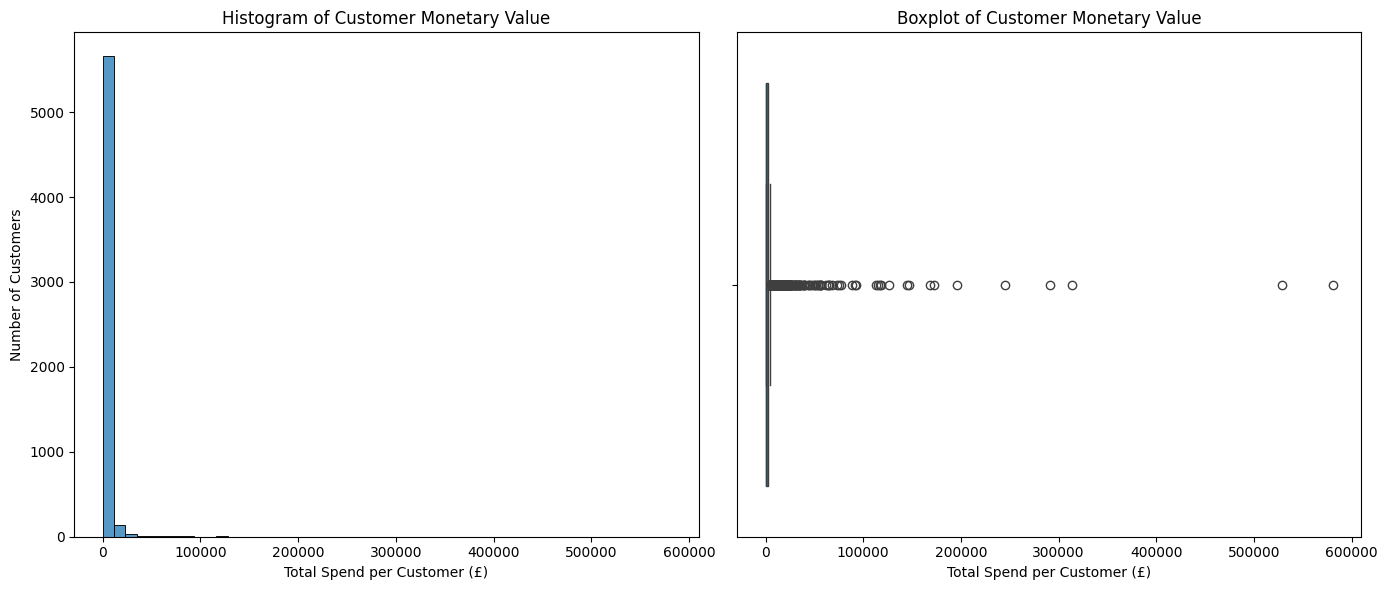

In [32]:
# --- Wholesaler Hypothesis: Distribution of Customer Monetary Value ---

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total spend per customer
monetary_per_customer = df.groupby('customer_id')['revenue'].sum()

plt.figure(figsize=(14,6))

# Histogram
plt.subplot(1,2,1)
sns.histplot(monetary_per_customer, bins=50, kde=False)
plt.title('Histogram of Customer Monetary Value')
plt.xlabel('Total Spend per Customer (£)')
plt.ylabel('Number of Customers')

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=monetary_per_customer)
plt.title('Boxplot of Customer Monetary Value')
plt.xlabel('Total Spend per Customer (£)')

plt.tight_layout()
plt.show()

### Explanation:

- The **histogram** shows the distribution of total spending per customer, illustrating that most customers spend relatively little, while a small number contribute significantly more.  
- The **boxplot** emphasizes the presence of outliers—customers with exceptionally high spending—who are likely **wholesalers**.  
- Identifying these high-value customers is essential for tailoring marketing strategies, pricing decisions, and special offers.  
- Together, these plots provide a visual foundation for distinguishing **retail customers** from **potential wholesale customers**.

### Strategic Recommendations by RFM Segment

Based on the RFM segmentation, we can tailor **marketing and engagement strategies** to each customer group.  
This ensures that high-value customers are rewarded, at-risk customers are re-engaged, and potential loyalists are nurtured effectively.

In [33]:
# --- Strategic Recommendations by RFM Segment ---

segment_actions = {
    "Champions": "Reward them with exclusive offers, early access to new products, and loyalty programs.",
    "Loyal Customers": "Upsell/cross-sell, offer referral incentives, and keep them engaged with regular updates.",
    "Potential Loyalists": "Nurture with onboarding emails, special discounts, and personalized recommendations.",
    "New Customers": "Welcome with onboarding, first-purchase discounts, and encourage repeat purchases.",
    "At-Risk Customers": "Send win-back campaigns, feedback surveys, and special reactivation offers.",
    "Hibernating": "Send re-engagement emails, highlight new arrivals, and offer time-limited discounts.",
    "Needs Attention": "Analyze their needs, send personalized offers, and test different engagement strategies."
}

print("Strategic Recommendations by Segment:\n")
for segment, action in segment_actions.items():
    count = (rfm_data['Segment'] == segment).sum()
    print(f"{segment} ({count} customers): {action}")

Strategic Recommendations by Segment:

Champions (1184 customers): Reward them with exclusive offers, early access to new products, and loyalty programs.
Loyal Customers (418 customers): Upsell/cross-sell, offer referral incentives, and keep them engaged with regular updates.
Potential Loyalists (301 customers): Nurture with onboarding emails, special discounts, and personalized recommendations.
New Customers (266 customers): Welcome with onboarding, first-purchase discounts, and encourage repeat purchases.
At-Risk Customers (316 customers): Send win-back campaigns, feedback surveys, and special reactivation offers.
Hibernating (1434 customers): Send re-engagement emails, highlight new arrivals, and offer time-limited discounts.
Needs Attention (1959 customers): Analyze their needs, send personalized offers, and test different engagement strategies.


### Explanation:

- Each RFM segment is associated with **targeted actions** based on customer behavior and value.  
- **Champions** and **Loyal Customers** are high-value, so the focus is on rewards, loyalty, and upselling.  
- **Potential Loyalists** and **New Customers** are nurtured with onboarding and personalized offers to encourage repeat purchases.  
- **At-Risk** and **Hibernating** customers need re-engagement campaigns to prevent churn.  
- **Needs Attention** customers require more analysis and experimentation to identify the best way to engage them.  

By implementing these strategies, businesses can **maximize retention, revenue, and customer lifetime value** in a structured and data-driven way.

## Phase 5: Data Enrichment via API Integration

In this phase, we enrich the **top 100 transactions** by converting their GBP revenue (`TotalPrice`) into **USD** and **EUR**.  

- This allows for **multi-currency analysis** of high-value transactions.  
- We provide a safe, error-free mechanism using **fixed fallback rates**.  
- Optionally, live exchange rates can be used if API access is available.

In [34]:
# Phase 5 – Data Enrichment with Currency Conversion
import pandas as pd

def enrich_top_transactions(df, n=100, use_live_api=False):
    """Enrich top n transactions with USD and EUR conversions."""
    
    # Sort transactions by TotalPrice
    df_top = df.nlargest(n, 'TotalPrice').copy()

    if use_live_api:
        import requests
        from datetime import datetime
        try:
            url = "https://api.exchangerate.host/latest?base=GBP&symbols=USD,EUR"
            response = requests.get(url, timeout=30)
            response.raise_for_status()
            data = response.json()
            rates = data.get("rates", {})
            usd_rate = rates.get("USD", 1.27)
            eur_rate = rates.get("EUR", 1.17)
            print("Using live exchange rates")
        except Exception as e:
            print(f"Live API failed ({e}), using fallback rates...")
            usd_rate, eur_rate = 1.27, 1.17
    else:
        usd_rate, eur_rate = 1.27, 1.17
        print("Using fixed fallback exchange rates")

    # Convert revenue
    df_top['TotalPrice_USD'] = df_top['TotalPrice'] * usd_rate
    df_top['TotalPrice_EUR'] = df_top['TotalPrice'] * eur_rate

    # Select final columns
    result = df_top[['invoice', 'invoicedate', 'TotalPrice', 'TotalPrice_USD', 'TotalPrice_EUR']]
    print("Currency conversion completed successfully!")
    return result


# ------------------- Run -------------------
print("Loading cleaned dataset...")
df = pd.read_csv('Data/online_retail_cleaned.csv', parse_dates=['invoicedate'])

# Make sure column is named TotalPrice (as in previous phases)
df['TotalPrice'] = df['quantity'] * df['price']

try:
    print("Processing top 100 transactions...")
    enriched_transactions = enrich_top_transactions(df, n=100, use_live_api=False)

    print("\nTop Transactions with Currency Conversions:")
    print(enriched_transactions.head())

    enriched_transactions.to_csv('Data/top_transactions_enriched.csv', index=False)
    print("\n Data saved successfully to 'Data/top_transactions_enriched.csv'")

except Exception as e:
    print(f"An error occurred: {str(e)}")

Loading cleaned dataset...
Processing top 100 transactions...
Using fixed fallback exchange rates
Currency conversion completed successfully!

Top Transactions with Currency Conversions:
        invoice         invoicedate  TotalPrice  TotalPrice_USD  \
778958   581483 2011-12-09 09:15:00    168469.6      213956.392   
423253   541431 2011-01-18 10:01:00     77183.6       98023.172   
540311   556444 2011-06-10 15:28:00     38970.0       49491.900   
333149   530715 2010-11-04 11:36:00     15818.4       20089.368   
96834    502263 2010-03-23 15:22:00     10953.5       13910.945   

        TotalPrice_EUR  
778958      197109.432  
423253       90304.812  
540311       45594.900  
333149       18507.528  
96834        12815.595  

 Data saved successfully to 'Data/top_transactions_enriched.csv'


### Explanation:

- We identify the **top 100 transactions** by `TotalPrice` to focus on high-value sales.  
- Revenue is converted from **GBP to USD and EUR** using either **live API rates** (if enabled) or **fixed fallback rates** to avoid errors.  
- The new columns `TotalPrice_USD` and `TotalPrice_EUR` provide multi-currency insights for analysis and reporting.  
- Exporting the enriched data to CSV ensures **reproducibility** and allows further international revenue analysis.  
- This enrichment supports **financial reporting**, **pricing decisions**, and helps understand transaction values in a global context.
